In [ ]:
from PIL import Image
import numpy as np
import itertools
import cv2
from math import cos,sin
from matplotlib import pyplot as plt
from skimage import data, feature
#from google.colab.patches import cv2_imshow

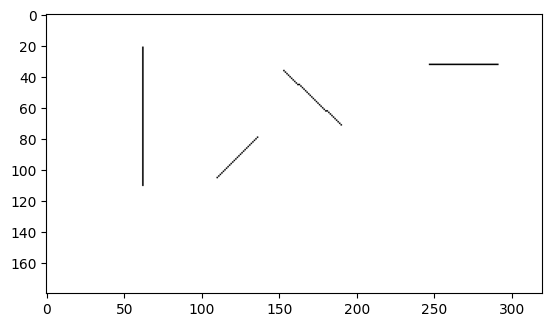

In [ ]:
image_path = 'pixel.png'
image = Image.open(image_path)
image_bw = image.convert('L')
plt.imshow(image_bw, cmap='gray')
plt.show()

In [ ]:
def hough_line(img):
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))  # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

In [ ]:
def plot_hough_lines(original_image, hough_lines, thetas, rhos):
    fig, ax = plt.subplots()
    ax.imshow(original_image, cmap=plt.cm.gray)
    for _, angle, dist in hough_lines:
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - original_image.shape[1] * np.cos(angle)) / np.sin(angle)
        ax.plot((0, original_image.shape[1]), (y0, y1), '-r')
    ax.set_xlim((0, original_image.shape[1]))
    ax.set_ylim((original_image.shape[0], 0))
    ax.set_axis_off()
    ax.set_title('Detected lines')
    plt.show()

In [ ]:
def plot_hough_space(accumulator, thetas, rhos):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(accumulator, cmap='jet', extent=[np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]), rhos[0], rhos[-1]])
    ax.set_title('Hough space')
    ax.set_xlabel('Theta (degrees)')
    ax.set_ylabel('Rho')
    ax.set_xlim(np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]))
    ax.set_ylim(rhos[0], rhos[-1])
    plt.show()

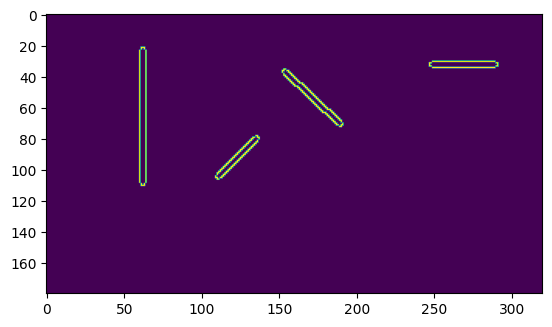

<ipython-input-4-1280e2f06180>:5: RuntimeWarning: divide by zero encountered in double_scalars
  y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
<ipython-input-4-1280e2f06180>:6: RuntimeWarning: divide by zero encountered in double_scalars
  y1 = (dist - original_image.shape[1] * np.cos(angle)) / np.sin(angle)


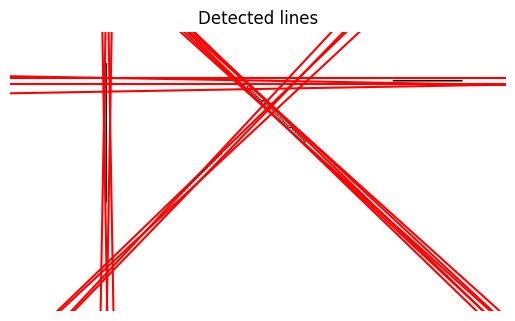

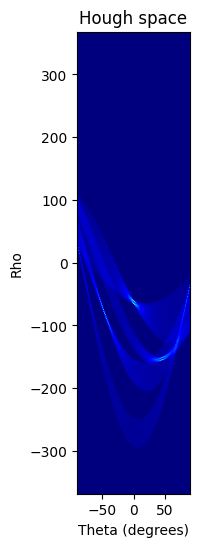

In [ ]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img_blur = cv2.GaussianBlur(image, (5, 5), 1)
edges = feature.canny(img_blur, sigma=1)

accumulator, thetas, rhos = hough_line(edges)
threshold = 35
idxs = np.nonzero(accumulator > threshold)

# Find the lines in Hough space
hough_lines = []
for i in range(len(idxs[0])):
    rho = rhos[idxs[0][i]]
    theta = thetas[idxs[1][i]]
    hough_lines.append((idxs[0][i], theta, rho))

plt.figure()
plt.imshow(edges) 
plt.show()
plot_hough_lines(image, hough_lines, thetas, rhos)
plot_hough_space(accumulator, thetas, rhos)

convert the given image to a binary image by applying a threshold. Then create a new image of the same size and set its pixel values based on the thresholding condition. If the pixel value of the input image is less than the threshold, the corresponding pixel value in the filtered image is set to 0, otherwise, it is set to 255. display the filtered image

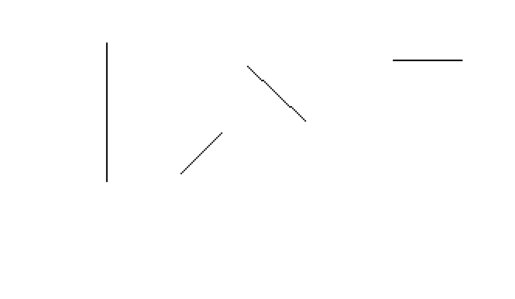

In [ ]:
pixels = image_bw.load()
width, height = image_bw.size
threshold = 10

filtered_image = Image.new('L', image_bw.size)
filtered_pixels = filtered_image.load()

for x in range(image_bw.width):
    for y in range(image_bw.height):
        if pixels[x, y] < threshold:
            filtered_pixels[x, y] = 0
        else:
            filtered_pixels[x, y] = 255
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')
plt.show()

Calculate the polar coordinates of all the black (pixel value 0) pixels in the filtered image. Initialize a variable center to (0, 0), which is the center of the image. Then, create an empty list called polar_coordinates to store the (r, theta) coordinates of all the black pixels.

Loop through each pixel in the filtered image and check if its value is 0. If the pixel is black, calculate its distance from the center using the Euclidean distance formula, and its angle (theta) relative to the center using the arctan2 function.Append the (r, theta) to the polar_coordinates list.

In [ ]:
center = (0,0)
polar_coordinates = []

for x in range(width):
  for y in range(height):
    if (filtered_pixels[x,y] == 0):
      r = np.sqrt((center[0] - x) ** 2 + (center[1] - y) ** 2)
      theta = np.arctan2(y - center[1], x - center[0])
      polar_coordinates.append((r,theta))
polar_coordinates

[(65.45991139621256, 0.3265814346906185),
 (65.7875368135941, 0.3409789534963494),
 (66.12866246946176, 0.35523086204668164),
 (66.48308055437865, 0.3693336576736256),
 (66.85057965343307, 0.3832841477456856),
 ...  (288.7784618007375, 0.11103963033307515),
 (289.77232442039735, 0.11065722117389565),
 (290.766229125736, 0.11027742628140852),
 (291.7601754866486, 0.10990021904748945),
 (292.7541630788536, 0.1095255732224159)]

Plot all the points which are converted into polar coordinates

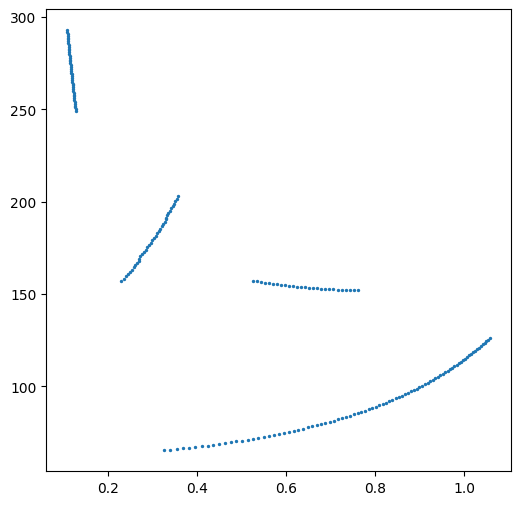

In [ ]:
r_values, theta_values = zip(*polar_coordinates)

fig = plt.figure(figsize=(6,6))
plt.scatter(theta_values, r_values, s=2)
plt.show()

Calculate the distance between all the pair of points

In [ ]:
distances = {}
for point1, point2 in itertools.combinations(polar_coordinates, 2):
    r1, t1 = point1
    r2, t2 = point2
    distance = np.sqrt((r2*np.cos(t2) - r1*np.cos(t1))**2 + (r2*np.sin(t1) - r1*np.cos(t1))**2)
    distances[distance] = (point1, point2)
# for distance in sorted(distances.keys()):
#     point1, point2 = distances[distance]
#     print(f"Points: {point1}, {point2} | Distance: {distance:.2f}")

Initialize some parameters for our line segment detection: 

*   **threshold** for the difference in theta
*   **threshold_r** for the difference in radius between two points
*   **min_points** for the minimum number of points required for a line segment.

We iterate through the polar coordinates. For each point, we calculate the differences in radius and theta between the current point and the previous one.

If the difference in theta or radius is greater than the **threshold**, we consider this a break between line segments. If we have already collected some points in the current segment and there are at least **min_points** of them, we add the current segment to the list of line segments.

At the end of the loop, we check if there are any remaining points in the current segment and add it to the list of line segments if it has at least **min_points** points. The resulting list of line segments is stored in line_segments.

In [ ]:
threshold = 0.1
threshold_r = 10
min_points = 5

prev_r = None
prev_theta = None
line_segments = []
current_segment = []

for i, (r, theta) in enumerate(polar_coordinates):
    if prev_theta is not None:
        delta_r = abs(r - prev_r)
        delta_theta = abs(theta - prev_theta)
        if delta_theta > threshold or delta_r > threshold_r:
            if len(current_segment) >= min_points:
                print(f"Break between points {(prev_r,prev_theta)} and {(r,theta)}")
                line_segments.append(current_segment)
            current_segment = [] 
        current_segment.append((r, theta))
    prev_theta = theta
    prev_r = r

if current_segment and len(current_segment) >= min_points:
    line_segments.append(current_segment)

for segment in line_segments:
    print("Segment:")
    for point in segment:
        print(point)

Break between points (126.26955294131677, 1.0575440539286356) and (152.0690632574555, 0.7621465405869854)
Break between points (157.2800050864699, 0.526243786855847) and (157.17824276915684, 0.23109066719589708)
Break between points (202.8324431643025, 0.35761660269291196) and (249.06424873915566, 0.12883703624687393)
Segment:
(65.7875368135941, 0.3409789534963494)
(66.12866246946176, 0.35523086204668164)
(66.48308055437865, 0.3693336576736256)
 ... (123.664869708418, 1.045632231036215)
(124.53112060846478, 1.0496581833107783)
(125.39936203984452, 1.0536284493347754)
(126.26955294131677, 1.0575440539286356)
Segment:
(152.0690632574555, 0.7621465405869854)
(152.10851389715174, 0.7528515207793263)
(152.16109883935513, 0.7435621232836686)
 ... (156.24659996300718, 0.5524935567554632)
(156.5790535161073, 0.5437053592006207)
(156.92354826475216, 0.5349550737860964)
(157.2800050864699, 0.526243786855847)
Segment:
(157.17824276915684, 0.23109066719589708)
(158.38244852255568, 0.23579056028370

**is_collinear(segment)** takes a list of polar coordinates representing a line segment and check if the points are collinear. calculate the slope between each pair of points in the segment, and convert the slopes to angles. check if the angles are approximately equal and calculate the angle between the first and last points in the segment.if the difference between the calculated angle and mean is less than some threshold then consider the points to be collinear and returns the angle.

Loop through each line segment in the **line_segments** list and **is_collinear(segment)** is used to check if the segment represents a straight line. If it does then calculate the angle of the line in degrees

In [ ]:
def is_collinear(segment):
    # Calculate the slope between each pair of points in the segment
    slopes = []
    for i in range(len(segment) - 1):
        r1, theta1 = segment[i]
        r2, theta2 = segment[i+1]
        if r2 * np.cos(theta2) == r1 * np.cos(theta1):
            # if the segment is vertical
            slope = np.inf
        else:
            # calculate slope using polar coordinates
            slope = (r2 * np.sin(theta2) - r1 * np.sin(theta1)) / (r2 * np.cos(theta2) - r1 * np.cos(theta1))
        slopes.append(slope)
    
    # convert slopes to angles
    angles = []
    for slope in slopes:
        if slope == np.inf or -np.inf:
            angle = np.pi/2
        else:
            angle = np.arctan(slope)
        angles.append(angle)
    
    # check if angles are approximately equal
    mean_angle = np.mean(angles)
    for angle in angles:
        if abs(angle - mean_angle) > 0.1:
            return None
    
    # calculating the angle between the first and last points in the segment
    r1, theta1 = segment[0]
    r2, theta2 = segment[-1]
    dx = r2 * np.cos(theta2) - r1 * np.cos(theta1)
    dy = r2 * np.sin(theta2) - r1 * np.sin(theta1)
    if dx == 0:
        angle = np.pi/2
    else:
        angle = np.arctan2(dy, dx)
    return angle

In [ ]:
new_line_segments = []
for segment in line_segments:
  #check if the points in the 'line_segments' belongs to a single line
  angle = is_collinear(segment)
  if angle is not None:
    #if slope of linesegment is not none then add it to new_line_segment
    new_line_segments.append((segment))
    angle = np.degrees(angle)     #converting radians to degrees
    print(f"Line segment with angle {angle}")
line_segments = new_line_segments
for segments in line_segments:
  print("segment : ")
  for point in segments:
    print(point)

Line segment with angle 90.0
Line segment with angle -45.00000000000002
Line segment with angle 43.40885972880541
Line segment with angle 0.0
segment : 
(65.7875368135941, 0.3409789534963494)
(66.12866246946176, 0.35523086204668164)
(66.48308055437865, 0.3693336576736256)
 ... (124.53112060846478, 1.0496581833107783)
(125.39936203984452, 1.0536284493347754)
(126.26955294131677, 1.0575440539286356)
segment : 
(152.0690632574555, 0.7621465405869854)
(152.10851389715174, 0.7528515207793263)
(152.16109883935513, 0.7435621232836686)
 ... (156.24659996300718, 0.5524935567554632)
(156.5790535161073, 0.5437053592006207)
(156.92354826475216, 0.5349550737860964)
(157.2800050864699, 0.526243786855847)
segment : 
(157.17824276915684, 0.23109066719589708)
(158.38244852255568, 0.2357905602837064)
(159.5900999435742, 0.24041942420085866)
 ... (200.26232796010336, 0.35175734282913)
(201.54652068443156, 0.35470565201094034)
(202.8324431643025, 0.35761660269291196)
segment : 
(249.06424873915566, 0.1288

create empty lists x_val and y_val for storing the x and y values of the line segments. Then loop through each line segment and check if it is collinear. If the line is collinear then extract the x and y values for each point in the line segment by converting the polar coordinates to Cartesian coordinates using the equations `x = rcos(theta) and y = height - rsin(theta)`, where height is the height of the image. stores these x and y values in the x_val and y_val. plot each line segment individually and then finally plots all the line segments on the same plot.

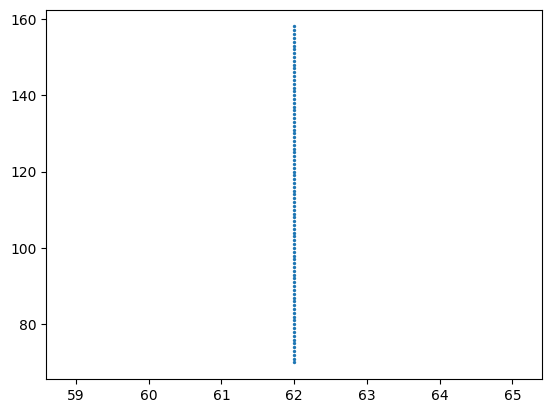

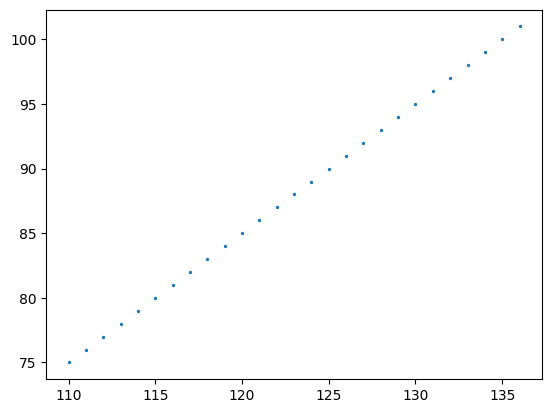

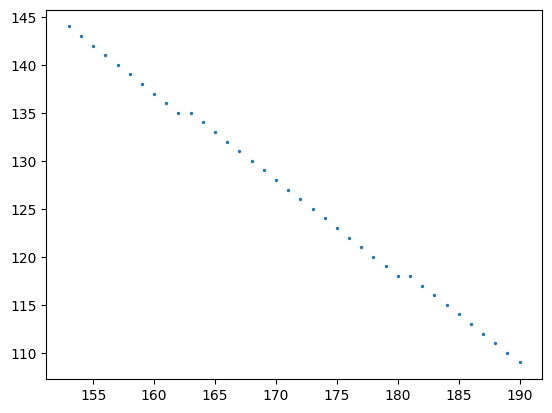

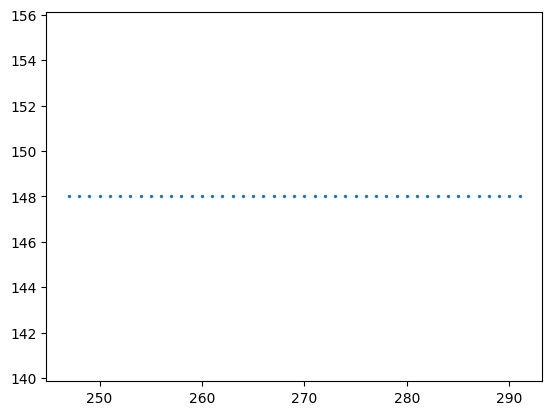

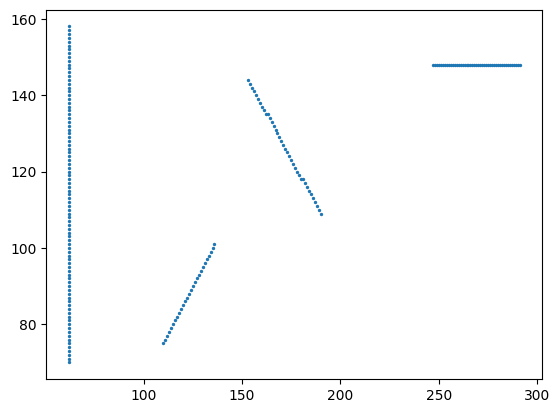

In [ ]:
#initializing the lists to store x and y values
x_val=[]
y_val=[]

#looping through all the linesegments and plotting them individually
for segment in line_segments:
#   line = is_collinear(segment)
#   if line is not None:
    x_temp_vals = []
    y_temp_vals = []
    for r, theta in segment:
            x = r * np.cos(theta)
            y = height - (r * np.sin(theta))
            x_temp_vals.append(x)
            y_temp_vals.append(y)
            x_val.append(x)
            y_val.append(y)
    plt.scatter(x_temp_vals, y_temp_vals, s=2)
    plt.show()

#plot all line segments
plt.scatter(x_val, y_val, s=2)
plt.show()

loop through all line segments, checks if they are collinear and if they are, add their first and last points to a list **end_points**.

In [ ]:
def list_of_endpoints():
  end_points = []
  for segment in line_segments:
      first_point = segment[0] #first point in the list of 'segment'
      last_point = segment[-1] #last point in the list of 'segment'
      end_points.append((first_point, last_point))  #append the first and last point
  return end_points

end_points = list_of_endpoints()
print(end_points)

[((65.7875368135941, 0.3409789534963494), (126.26955294131677, 1.0575440539286356)), ((152.0690632574555, 0.7621465405869854), (157.2800050864699, 0.526243786855847)), ((157.17824276915684, 0.23109066719589708), (202.8324431643025, 0.35761660269291196)), ((249.06424873915566, 0.12883703624687393), (292.7541630788536, 0.1095255732224159))]


Distance between first and last point in the list of **end_points**. this gives the length of a line segment. the distance is calulated as $$\sqrt(r_1**2+r_2**2 - 2*r_1*r_2*cos(\theta_2-\theta_1))$$

In [ ]:
def distance(lst_of_points):
    first_point,second_point = lst_of_points
    r1,t1 = first_point
    r2,t2 = second_point
    dist = np.sqrt(r1**2+r2**2 - 2*r1*r2*np.cos(t2-t1))
    return dist
for points in end_points:
  d = distance(points)
  print(f"distance between {points[0]} and {points[1]} is {d}")

distance between (65.7875368135941, 0.3409789534963494) and (126.26955294131677, 1.0575440539286356) is 88.0
distance between (152.0690632574555, 0.7621465405869854) and (157.2800050864699, 0.526243786855847) is 36.76955262170037
distance between (157.17824276915684, 0.23109066719589708) and (202.8324431643025, 0.35761660269291196) is 50.931326312987444
distance between (249.06424873915566, 0.12883703624687393) and (292.7541630788536, 0.1095255732224159) is 44.0


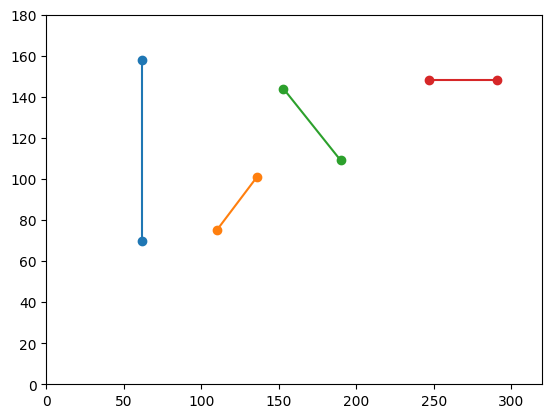

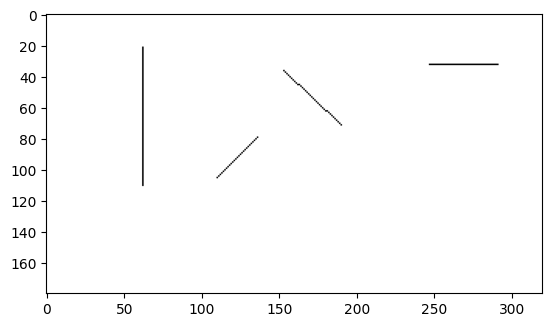

In [ ]:
for segment in end_points:
    first_point = segment[0]
    last_point = segment[1]

  #converting points from polar-coordinate space to cartesian space
    x1 = first_point[0] * np.cos(first_point[1])
    y1 = height - (first_point[0] * np.sin(first_point[1]))
    x2 = last_point[0] * np.cos(last_point[1])
    y2 = height - (last_point[0] * np.sin(last_point[1]))

    plt.plot([x1, x2], [y1, y2], '-o')
    plt.xlim(0,width)
    plt.ylim(0,height)
plt.show()
plt.imshow(image, cmap='gray')
plt.show()